In [ ]:
!pip install python-dp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 20.0 MB/s eta 0:00:00


In [ ]:
import pydp
print("PyDP funcionando en Google Colab")

PyDP funcionando en Google Colab


In [ ]:
# Instalar librería si no está
!pip install vega_datasets


import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import files
from scipy.stats import trim_mean

# 1º Subo el archivo
uploaded = files.upload()

# 2º Obtener el contenido del archivo
archivo = list(uploaded.values())[0]

#3º Leo la hoja que indico
df = pd.read_excel(archivo, sheet_name="base_de_datos_limpia")

# Renombro las columnas
df = df.rename(columns={'Countries territories and areas': 'country', 'Sex': 'sex'})

# Transformo la dimension de los datos
# melt cambia los años de columnas a filas, fijo country y sex con id_vars, entonces se que debo cambiar el resto columnas con var_name y value_name son los valores de esas columas
#les asigno esos nombres a los años year y a las tasas de suicidio suicide_rate
df_new = df.melt(id_vars=['country', 'sex'], var_name='year', value_name='suicide_rate')

#por defecto melt me deja los valores tipo str, lo cambio a int
df_new['year'] = df_new['year'].astype(int)

#Asigno indices nuevos y redorneo en el siguiente orden: pais año y sexo, igual que en el inicial
df_new = df_new.sort_values(by=['country', 'year', 'sex']).reset_index(drop=True)


# Media acotada del 20% superior e inferior de cada año,para eliminar outliers
# Crear lista para almacenar filas nuevas


filas_media = []

# Calcular media acotada para cada combinación de año y sexo
for year in df_new['year'].unique():
    for sex in ['Male', 'Female', 'Both sexes']:
        media = trim_mean(df_new[(df_new['year'] == year) & (df_new['sex'] == sex)]['suicide_rate'], proportiontocut=0.2)

        fila = {
            'country': 'country_media',
            'sex': sex,
            'year': year,
            'suicide_rate': media
        }
        filas_media.append(fila)

# Convertir a DataFrame
df_media = pd.DataFrame(filas_media)

# Concateno al principio del DataFrame original, primero country_media
df_final = pd.concat([df_media, df_new], ignore_index=True)

df_final.head()


Saving base_de_datos_limpia.xlsx to base_de_datos_limpia.xlsx


<ipython-input-3-2146569986>:18: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  df = pd.read_excel(archivo, sheet_name="base_de_datos_limpia")


,country,sex,year,suicide_rate
0,country_media,Male,2000,17.432432
1,country_media,Female,2000,5.589189
2,country_media,Both sexes,2000,11.365766
3,country_media,Male,2001,17.127928
4,country_media,Female,2001,5.510811


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Parámetros de modelos
mlp_config = (256, 128) #Redes neuronales
n_tree = 300            #Random Forest

# Lista de modelos
modelos = [
    ('MLP', MLPRegressor(hidden_layer_sizes=mlp_config,
                         activation='relu',            #Función de activación ReLU
                         solver='adam',                #Optimización con Adam
                         alpha=0.0001,                  #Regularización
                         learning_rate_init=0.01,      #Paso de aprendizaje
                         max_iter=1000,                # Maximo número de iteraciones
                         random_state=42)),            #Para reproducibilidad

    ('RF', RandomForestRegressor(n_estimators=n_tree, random_state=42)),

    ('RidgeRegression', Ridge(alpha=1e-5)),

    ('LinearRegression', LinearRegression())
]


resultados_globales_2015_2019 = []
predicciones_detalladas_2015_2019 = []

# Recorrer modelos
for model_name, model in modelos:
    print(f"\n Evaluando modelo: {model_name}")

    # Recorrer España y country_media para male, female y Both_sexes
    for pais in ['Spain', 'country_media']:
        for sexo in ['Male', 'Female', 'Both sexes']:
            data = df_final[(df_final['country'] == pais) & (df_final['sex'] == sexo)]

             #Separar entrenamiento y evaluación
            train = data[data['year'] <= 2014] #Cojo los datos hasta 2014 para entrenar el modelo
            test = data[(data['year'] >= 2015) & (data['year'] <= 2019)] #cojo de 2015 a 2019 para test

            if train.empty or test.empty:
                continue

            X_train = train[['year']] #Año de cada dato de entrenamiento, Variable independiente para entrenar
            y_train = train['suicide_rate'] #Dato de cada año de entrenamiento, Variable objetivo a predecir
            X_test = test[['year']] #Años del conjunto de prueba, Entrada para predicciones
            y_test = test['suicide_rate'] #Tasa de suicidio real en esos años, Para comparar con las predicciones

            # Escalar si es MLP
            if model_name == 'MLP':
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            # Guardar predicciones
            for year, real, pred in zip(X_test['year'], y_test, y_pred): #zip puede unir varias listas y recorrerlas al mismo tiempo
                predicciones_detalladas_2015_2019.append({
                    'modelo': model_name,
                    'country': pais,
                    'sex': sexo,
                    'year': year,
                    'real': real,
                    'pred': pred
                })

# Convertir predicciones a DataFrame
df_preds = pd.DataFrame(predicciones_detalladas_2015_2019)

# Evaluar globalmente por modelo
for model_name in df_preds['modelo'].unique():
    df_model = df_preds[df_preds['modelo'] == model_name]
    mae = mean_absolute_error(df_model['real'], df_model['pred'])
    rmse = np.sqrt(mean_squared_error(df_model['real'], df_model['pred']))
    resultados_globales_2015_2019.append({
        'modelo': model_name,
        'MAE_global': mae, #Evaluo con error medio absoluto
        'RMSE_global': rmse #Root Mean Squared Error
    })

# Mostrar predicciones por año
print("\n Predicciones detalladas por país, sexo y año:")
print(df_preds.sort_values(['modelo', 'country', 'sex', 'year']))

# Mostrar evaluación global
df_resultados = pd.DataFrame(resultados_globales_2015_2019).sort_values('MAE_global')
print("\n Evaluación global (ordenado por MAE):")
print(df_resultados)



 Evaluando modelo: MLP

 Evaluando modelo: RF

 Evaluando modelo: RidgeRegression

 Evaluando modelo: LinearRegression

 Predicciones detalladas por país, sexo y año:
               modelo        country         sex  year       real       pred
100  LinearRegression          Spain  Both sexes  2015   5.600000   5.453333
101  LinearRegression          Spain  Both sexes  2016   5.500000   5.398333
102  LinearRegression          Spain  Both sexes  2017   5.800000   5.343333
103  LinearRegression          Spain  Both sexes  2018   5.400000   5.288333
104  LinearRegression          Spain  Both sexes  2019   5.300000   5.233333
..                ...            ...         ...   ...        ...        ...
75    RidgeRegression  country_media        Male  2015  14.123423  14.150296
76    RidgeRegression  country_media        Male  2016  13.843243  13.944016
77    RidgeRegression  country_media        Male  2017  13.683784  13.737735
78    RidgeRegression  country_media        Male  2018  13.495

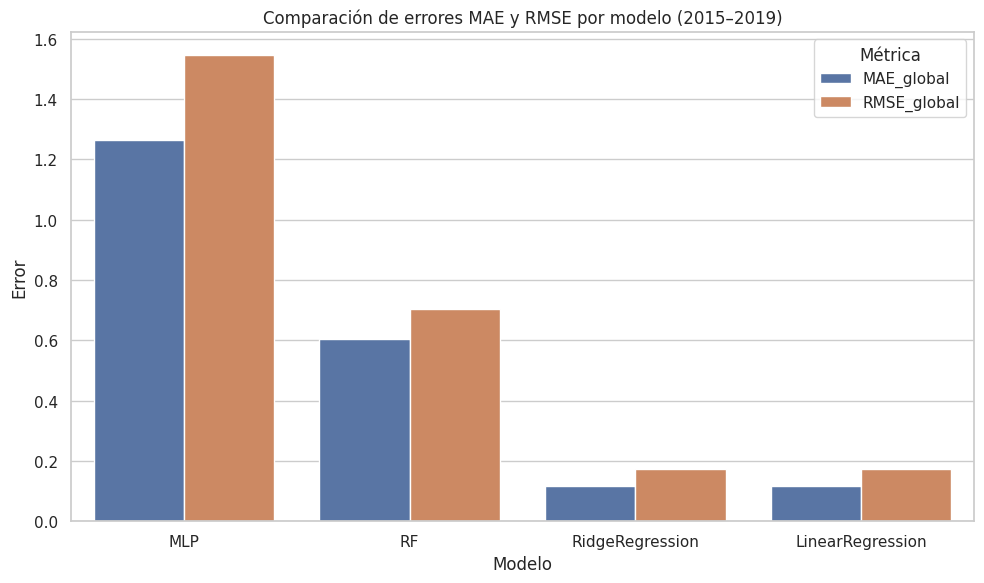

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame de resultados si no está creado
df_resultados = pd.DataFrame(resultados_globales_2015_2019)

# Establecer estilo
sns.set(style="whitegrid")

# Crear gráfico de barras para MAE y RMSE
fig, ax = plt.subplots(figsize=(10, 6))
df_plot = df_resultados.melt(id_vars="modelo", value_vars=["MAE_global", "RMSE_global"],
                             var_name="Métrica", value_name="Error")

sns.barplot(data=df_plot, x="modelo", y="Error", hue="Métrica", ax=ax)

# Títulos y etiquetas
ax.set_title("Comparación de errores MAE y RMSE por modelo (2015–2019)")
ax.set_xlabel("Modelo")
ax.set_ylabel("Error")
plt.xticks(rotation=0)
plt.legend(title="Métrica")

plt.tight_layout()
plt.show()


In [ ]:
# Predicción futura (2020–2024) con LinearRegression

from sklearn.linear_model import LinearRegression

predicciones_lr_futuras_2020_2024 = []

modelo_lr = LinearRegression()

print("\n Generando predicciones futuras con LinearRegression")

for pais in ['Spain', 'country_media']:
    for sexo in ['Male', 'Female', 'Both sexes']:
        data = df_final[(df_final['country'] == pais) & (df_final['sex'] == sexo)]

        # Entrenar con todos los datos disponibles hasta 2019
        train = data[(data['year'] >= 2005) & (data['year'] <= 2019)] #cojo de 2005 a 2019 para train

        if train.empty:
            continue

        X_train = train[['year']]
        y_train = train['suicide_rate']

        # Crear años futuros: 2020–2024
        X_future = pd.DataFrame({'year': list(range(2020, 2025))})

        modelo_lr.fit(X_train, y_train)
        y_pred = modelo_lr.predict(X_future)

        for year, pred in zip(X_future['year'], y_pred):
            predicciones_lr_futuras_2020_2024.append({
                'modelo': 'LinearRegression',
                'country': pais,
                'sex': sexo,
                'year': year,
                'pred': pred
            })

# Convertir a DataFrame
df_preds_lr_futuras = pd.DataFrame(predicciones_lr_futuras_2020_2024)

# Mostrar predicciones ordenadas
print("\n Predicciones futuras (2020–2024) con LinearRegression:")
print(df_preds_lr_futuras.sort_values(['country', 'sex', 'year']))



 Generando predicciones futuras con LinearRegression

 Predicciones futuras (2020–2024) con LinearRegression:
              modelo        country         sex  year       pred
10  LinearRegression          Spain  Both sexes  2020   5.556190
11  LinearRegression          Spain  Both sexes  2021   5.549048
12  LinearRegression          Spain  Both sexes  2022   5.541905
13  LinearRegression          Spain  Both sexes  2023   5.534762
14  LinearRegression          Spain  Both sexes  2024   5.527619
5   LinearRegression          Spain      Female  2020   2.979048
6   LinearRegression          Spain      Female  2021   3.009762
7   LinearRegression          Spain      Female  2022   3.040476
8   LinearRegression          Spain      Female  2023   3.071190
9   LinearRegression          Spain      Female  2024   3.101905
0   LinearRegression          Spain        Male  2020   8.307619
1   LinearRegression          Spain        Male  2021   8.259405
2   LinearRegression          Spain        M

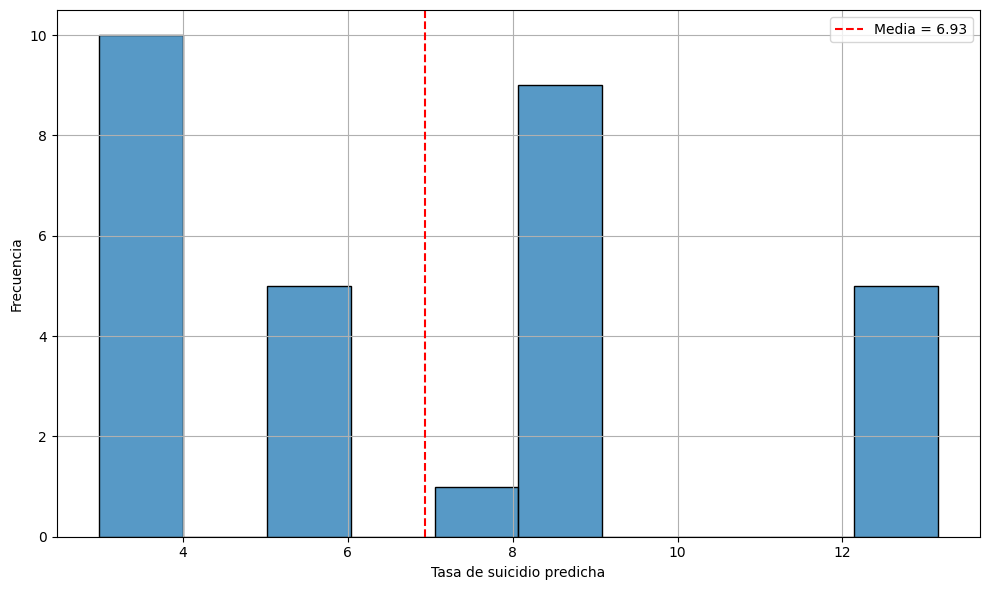

(np.float64(6.933718003718003), 11.130753263520212)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular media y varianza del conjunto total de predicciones
media_total = df_preds_lr_futuras['pred'].mean()
varianza_total = df_preds_lr_futuras['pred'].var()

# Crear histograma global de todas las predicciones (sin distinguir sexo ni país)
plt.figure(figsize=(10, 6))
sns.histplot(df_preds_lr_futuras['pred'], bins=10, kde=False)
plt.axvline(media_total, color='red', linestyle='--', label=f'Media = {media_total:.2f}')
plt.xlabel('Tasa de suicidio predicha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar media y varianza
(media_total, varianza_total)


In [ ]:
#CASO 1: AÑADO RUIDO A LAS PREDICCIONES FINALES
#Como representar esto, si lo quiero represntar

# Aplicar privacidad diferencial a las predicciones finales
# Funciones para añadir ruido
def add_laplace_noise(series, epsilon, sensitivity=1.0): #Columnas de predicciones a la que se le añade ruido, epsilon: parámetro de privacidad(a menor mas ruido), sesitivity sensibilidad de la funcion
    scale = sensitivity / epsilon #calcular prámetro b= sensitivity/epsilon
    noise = np.random.laplace(loc=0, scale=scale, size=series.shape) #"anchura" de la distribución (más epsilon menos ruido)
    return series + noise #añado el ruido a las predicciones

def add_gaussian_noise(series, epsilon, sensitivity=1.0, delta=1e-5): #delta es una pequeña probabilidad de que se viole la privacidad
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon #desviación estándar
    noise = np.random.normal(loc=0, scale=sigma, size=series.shape)
    return series + noise

# Valores de epsilon y delta
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]
delta = 1e-5
sensitivity = 1.0 #por defecto

np.random.seed(42)

# Lista para guardar los resultados con ruido
df_dp_all = []

for eps in epsilons:
    # Ruido Laplaciano
    df_lap = df_preds_lr_futuras.copy() #hacer copia de df_preds_lr_futuras, no afecto a la original
    df_lap['pred_dp'] = add_laplace_noise(df_lap['pred'], epsilon=eps, sensitivity=sensitivity) #añadir a la columna pred ruido laplaciano
    df_lap['epsilon'] = eps #Creo una nueva columna y guardo el valor de epsilon qe estoy usando en cada momento
    df_lap['mecanismo'] = 'laplace' #otra columna para el tipo de ruido
    df_dp_all.append(df_lap)

    # Ruido Gaussiano
    df_gauss = df_preds_lr_futuras.copy()
    df_gauss['pred_dp'] = add_gaussian_noise(df_gauss['pred'], epsilon=eps, sensitivity=sensitivity, delta=delta)
    df_gauss['epsilon'] = eps
    df_gauss['mecanismo'] = 'gaussian'
    df_dp_all.append(df_gauss)

# Unir todo en un solo DataFrame
df_privacidad_dif = pd.concat(df_dp_all, ignore_index=True)

# Añadir columna 'pred' (original sin ruido) al DataFrame
df_privacidad_dif['pred_sin_ruido'] = df_privacidad_dif['pred']

# Creo tabla comparativa

# Sin ruido
#Selecciono las 4 columnas que me interesan del dataframe
#Para cada combinacion de pais año y sexo me da la media de las predicciones sin ruido
pivot_original = df_privacidad_dif[['country', 'year', 'sex', 'pred_sin_ruido']].pivot_table(
    values='pred_sin_ruido', index=['country', 'year', 'sex'], aggfunc='mean'
).round(3) #redondeo 3 decimales
pivot_original.columns = ['sin_ruido'] #Asigno nombre

#Ruido Laplaciano
#Selecciono el ruido laplaciano
#Selecciono las predicciones con ruido pred_dp, agrupo por pais, año y sexo, creo una columna diferente para cada valor de epsilon
pivot_lap = df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'laplace'].pivot_table(
    values='pred_dp', index=['country', 'year', 'sex'], columns='epsilon', aggfunc='mean'
).round(3)
pivot_lap.columns = [f'laplace_{col}' for col in pivot_lap.columns]

#Ruido Gaussiano
pivot_gauss = df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'gaussian'].pivot_table(
    values='pred_dp', index=['country', 'year', 'sex'], columns='epsilon', aggfunc='mean'
).round(3)
pivot_gauss.columns = [f'gaussian_{col}' for col in pivot_gauss.columns]

# Unir todas las tablas
pivot_combined = pd.concat([pivot_original, pivot_lap, pivot_gauss], axis=1)

# Mostrar
print("\nResumen de predicciones con y sin ruido (por año, sexo y país):")
print(pivot_combined)



Resumen de predicciones con y sin ruido (por año, sexo y país):
                               sin_ruido  laplace_0.1  laplace_0.5  \
country       year sex                                               
Spain         2020 Both sexes      5.556      -26.345        6.786   
                   Female          2.979       -8.669        3.545   
                   Male            8.308        5.419        9.872   
              2021 Both sexes      5.549       33.653        6.193   
                   Female          3.010      -18.517        2.184   
                   Male            8.259       31.429        4.440   
              2022 Both sexes      5.542       16.475        8.520   
                   Female          3.040       16.221       -1.085   
                   Male            8.211       14.447        7.546   
              2023 Both sexes      5.535       -3.029        5.420   
                   Female          3.071        5.331        2.121   
                   Male  

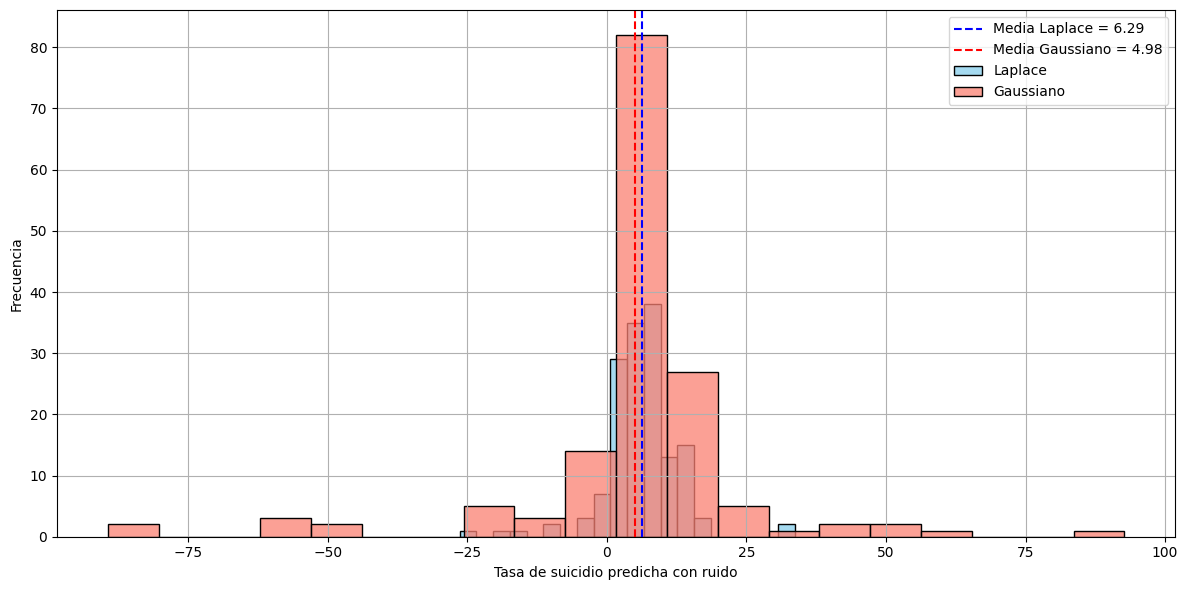

((np.float64(6.290259492690585), 45.046017905158976),
 (np.float64(4.9774789306314675), 416.5548936521024))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular media y varianza para cada mecanismo
media_laplace = df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'laplace']['pred_dp'].mean()
var_laplace = df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'laplace']['pred_dp'].var()

media_gauss = df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'gaussian']['pred_dp'].mean()
var_gauss = df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'gaussian']['pred_dp'].var()

# Crear el histograma
plt.figure(figsize=(12, 6))
sns.histplot(data=df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'laplace'], x='pred_dp', color='skyblue', label='Laplace', kde=False, bins=20)
plt.axvline(media_laplace, color='blue', linestyle='--', label=f'Media Laplace = {media_laplace:.2f}')

sns.histplot(data=df_privacidad_dif[df_privacidad_dif['mecanismo'] == 'gaussian'], x='pred_dp', color='salmon', label='Gaussiano', kde=False, bins=20)
plt.axvline(media_gauss, color='red', linestyle='--', label=f'Media Gaussiano = {media_gauss:.2f}')


plt.xlabel('Tasa de suicidio predicha con ruido')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(media_laplace, var_laplace), (media_gauss, var_gauss)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


evaluacion_ruido = []
# Iterar por tipo de ruido y epsilon
for mecanismo in ['laplace', 'gaussian']:
    for eps in epsilons:
        df_temp = df_privacidad_dif[
            (df_privacidad_dif['mecanismo'] == mecanismo) &
            (df_privacidad_dif['epsilon'] == eps)
        ]

# Valores reales (sin ruido) y predichos con ruido
        y_true = df_temp['pred_sin_ruido']
        y_pred = df_temp['pred_dp']

# Calcular métricas
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

# Guardar resultados
        evaluacion_ruido.append({
            'mecanismo': mecanismo,
            'epsilon': eps,
            'MAE': round(mae, 3),
            'RMSE': round(rmse, 3),
            'R2': round(r2,3)
        })

# Convertir a DataFrame
df_evaluacion_ruido = pd.DataFrame(evaluacion_ruido)

# Mostrar resultados ordenados
print("\nEvaluación MAE, RMSE y R2 según mecanismo y epsilon:")
print(df_evaluacion_ruido.sort_values(['mecanismo', 'epsilon']))


Evaluación MAE, RMSE y R2 según mecanismo y epsilon:
  mecanismo  epsilon     MAE    RMSE       R2
5  gaussian      0.1  36.805  44.783 -185.389
6  gaussian      0.5   5.887   7.787   -4.636
7  gaussian      1.0   3.773   4.388   -0.789
8  gaussian      5.0   0.763   1.014    0.905
9  gaussian     10.0   0.484   0.580    0.969
0   laplace      0.1   9.352  12.549  -13.636
1   laplace      0.5   1.750   2.363    0.481
2   laplace      1.0   0.979   1.376    0.824
3   laplace      5.0   0.207   0.281    0.993
4   laplace     10.0   0.093   0.132    0.998


In [ ]:
#Elimino un valor aleatorio
# media y varianza del conjunto completo de prediccionescon ruido
media_original = df_privacidad_dif['pred_dp'].mean()
varianza_original = df_privacidad_dif['pred_dp'].var()

# Eliminar aleatoriamente un dato
df_privacidad_dif_sin_un_dato = df_privacidad_dif.sample(frac=1, random_state=42).iloc[1:]  # Elimina una fila aleatoria, frac las baraja y se elige la primera

# media y varianza tras eliminar un dato
media_sin_dato = df_privacidad_dif_sin_un_dato['pred_dp'].mean()
varianza_sin_dato = df_privacidad_dif_sin_un_dato['pred_dp'].var()

df_comparacion = pd.DataFrame({
    'Conjunto': ['Original', 'Sin un dato'],
    'Media': [media_original, media_sin_dato],
    'Varianza': [varianza_original, varianza_sin_dato]
}).round(4)

print("\nComparación de media y varianza antes y después de eliminar un dato:")
print(df_comparacion)



Comparación de media y varianza antes y después de eliminar un dato:
      Conjunto   Media  Varianza
0     Original  5.6339  230.4608
1  Sin un dato  5.6410  231.2188


In [ ]:
# CASO 2: AÑADIR RUIDO A LOS DATOS DE ENTRENAMIENTO

# Funciones para añadir ruido de forma reproducible
def add_laplace_noise2(series, epsilon, sensitivity=1.0, rng=None):
    scale = sensitivity / epsilon
    noise = rng.laplace(loc=0, scale=scale, size=series.shape)
    return series + noise

def add_gaussian_noise2(series, epsilon, sensitivity=1.0, delta=1e-5, rng=None):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    noise = rng.normal(loc=0, scale=sigma, size=series.shape)
    return series + noise

# Parámetros de privacidad diferencial
epsilons2 = [0.1, 0.5, 1.0, 5.0, 10.0]
delta2 = 1e-5
sensitivity2 = 1.0

# Diccionario de seeds para mantener siempre los mismos valores
seeds_dict = {
    (0.1, 'laplace'): 1001,
    (0.1, 'gaussian'): 1002,
    (0.5, 'laplace'): 1003,
    (0.5, 'gaussian'): 1004,
    (1.0, 'laplace'): 1005,
    (1.0, 'gaussian'): 1006,
    (5.0, 'laplace'): 1007,
    (5.0, 'gaussian'): 1008,
    (10.0, 'laplace'): 1009,
    (10.0, 'gaussian'): 1010,
}

from sklearn.linear_model import LinearRegression

df_dp_all2 = []

for eps in epsilons2:
    for mecanismo, noise_func in [('laplace', add_laplace_noise2), ('gaussian', add_gaussian_noise2)]:
        rng = np.random.default_rng(seed=seeds_dict[(eps, mecanismo)])
        predicciones_con_ruido2 = []

        for pais in ['Spain', 'country_media']:
            for sexo in ['Male', 'Female', 'Both sexes']:
                data = df_final[(df_final['country'] == pais) & (df_final['sex'] == sexo)]
                train = data[(data['year'] >= 2005) & (data['year'] <= 2019)]

                if train.empty:
                    continue
# Añado ruido a los datos de entrenamiento
                X_train = train[['year']]
                y_train = train['suicide_rate']
                if mecanismo == 'gaussian':
                    y_train_ruido = noise_func(y_train, epsilon=eps, sensitivity=sensitivity2, delta=delta2, rng=rng)
                else:
                    y_train_ruido = noise_func(y_train, epsilon=eps, sensitivity=sensitivity2, rng=rng)

                modelo = LinearRegression()
                modelo.fit(X_train, y_train_ruido)

                X_future = pd.DataFrame({'year': list(range(2020, 2025))})
                y_pred = modelo.predict(X_future)

                for year, pred in zip(X_future['year'], y_pred):
                    predicciones_con_ruido2.append({
                        'modelo': 'LinearRegression',
                        'country': pais,
                        'sex': sexo,
                        'year': year,
                        'pred_dp': pred,
                        'epsilon': eps,
                        'mecanismo': mecanismo
                    })

        df_dp_all2.append(pd.DataFrame(predicciones_con_ruido2))

df_ruido = pd.concat(df_dp_all2, ignore_index=True)
df_ruido['pred_sin_ruido'] = df_privacidad_dif['pred']  # Suponiendo que esta ya existe

#tabla comparativa
pivot_original = df_ruido[['country', 'year', 'sex', 'pred_sin_ruido']].pivot_table(
    values='pred_sin_ruido', index=['country', 'year', 'sex'], aggfunc='mean'
).round(3)
pivot_original.columns = ['sin_ruido']

pivot_lap = df_ruido[df_ruido['mecanismo'] == 'laplace'].pivot_table(
    values='pred_dp', index=['country', 'year', 'sex'], columns='epsilon', aggfunc='mean'
).round(3)
pivot_lap.columns = [f'laplace_{col}' for col in pivot_lap.columns]

pivot_gauss = df_ruido[df_ruido['mecanismo'] == 'gaussian'].pivot_table(
    values='pred_dp', index=['country', 'year', 'sex'], columns='epsilon', aggfunc='mean'
).round(3)
pivot_gauss.columns = [f'gaussian_{col}' for col in pivot_gauss.columns]

pivot_combined = pd.concat([pivot_original, pivot_lap, pivot_gauss], axis=1)


print("\nResumen de predicciones (sin ruido vs ruido en y_train):")
print(pivot_combined)



Resumen de predicciones (sin ruido vs ruido en y_train):
                               sin_ruido  laplace_0.1  laplace_0.5  \
country       year sex                                               
Spain         2020 Both sexes      5.556       11.072        6.137   
                   Female          2.979       -0.150        9.735   
                   Male            8.308        1.543       14.127   
              2021 Both sexes      5.549       10.765        5.353   
                   Female          3.010       -1.871        9.849   
                   Male            8.259        1.617       14.690   
              2022 Both sexes      5.542       10.459        4.570   
                   Female          3.040       -3.592        9.963   
                   Male            8.211        1.691       15.252   
              2023 Both sexes      5.535       10.152        3.787   
                   Female          3.071       -5.314       10.077   
                   Male         

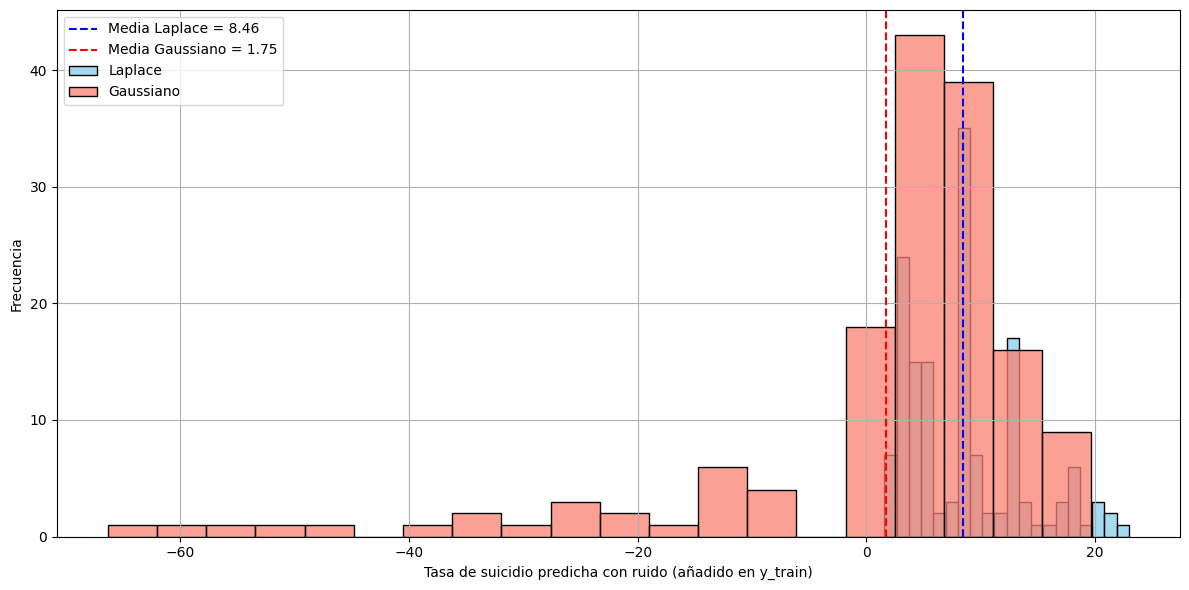

((np.float64(8.459859976308161), 25.74898479235597),
 (np.float64(1.7535387774688327), 229.43233808247345))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# media y varianza para cada mecanismo en el caso 2
media_laplace_2 = df_ruido[df_ruido['mecanismo'] == 'laplace']['pred_dp'].mean()
var_laplace_2 = df_ruido[df_ruido['mecanismo'] == 'laplace']['pred_dp'].var()

media_gauss_2 = df_ruido[df_ruido['mecanismo'] == 'gaussian']['pred_dp'].mean()
var_gauss_2 = df_ruido[df_ruido['mecanismo'] == 'gaussian']['pred_dp'].var()

#histograma para el caso 2
plt.figure(figsize=(12, 6))
sns.histplot(data=df_ruido[df_ruido['mecanismo'] == 'laplace'], x='pred_dp', color='skyblue', label='Laplace', kde=False, bins=20)
plt.axvline(media_laplace_2, color='blue', linestyle='--', label=f'Media Laplace = {media_laplace_2:.2f}')

sns.histplot(data=df_ruido[df_ruido['mecanismo'] == 'gaussian'], x='pred_dp', color='salmon', label='Gaussiano', kde=False, bins=20)
plt.axvline(media_gauss_2, color='red', linestyle='--', label=f'Media Gaussiano = {media_gauss_2:.2f}')

plt.xlabel('Tasa de suicidio predicha con ruido (añadido en y_train)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(media_laplace_2, var_laplace_2), (media_gauss_2, var_gauss_2)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score
import numpy as np
import pandas as pd


evaluacion_ruido2 = []

for mecanismo in ['laplace', 'gaussian']:
    for eps in epsilons:
        df_temp2 = df_ruido[
            (df_ruido['mecanismo'] == mecanismo) &
            (df_ruido['epsilon'] == eps)
        ]

# Valores reales sin ruido y predichos con ruido
        y_true2 = df_temp2['pred_sin_ruido']
        y_pred2 = df_temp2['pred_dp']

# Calculo métricas
        mae2 = mean_absolute_error(y_true2, y_pred2)
        rmse2 = np.sqrt(mean_squared_error(y_true2, y_pred2))
        r2_2 = r2_score(y_true2, y_pred2)

        evaluacion_ruido2.append({
            'mecanismo': mecanismo,
            'epsilon': eps,
            'MAE': round(mae2, 3),
            'RMSE': round(rmse2, 3),
            'R2': round(r2_2, 3)
       })

df_evaluacion_ruido2 = pd.DataFrame(evaluacion_ruido2)

print("\nEvaluación MAE, RMSE y R2 según mecanismo y epsilon en el segundo caso:")
print(df_evaluacion_ruido2.sort_values(['mecanismo', 'epsilon']))



Evaluación MAE, RMSE y R2 según mecanismo y epsilon en el segundo caso:
  mecanismo  epsilon     MAE    RMSE       R2
5  gaussian      0.1  29.978  34.514 -109.712
6  gaussian      0.5   2.930   3.250    0.018
7  gaussian      1.0   2.068   2.280    0.517
8  gaussian      5.0   0.660   0.745    0.948
9  gaussian     10.0   0.325   0.419    0.984
0   laplace      0.1   7.960   9.375   -7.168
1   laplace      0.5   0.798   0.997    0.908
2   laplace      1.0   0.423   0.534    0.974
3   laplace      5.0   0.182   0.202    0.996
4   laplace     10.0   0.110   0.170    0.997


In [ ]:
#media y varianza del conjunto completo de predicciones del caso 2
media_original_caso2 = df_ruido['pred_dp'].mean()
varianza_original_caso2 = df_ruido['pred_dp'].var()

# Elimino aleatoriamente un dato del conjunto de predicciones con ruido
df_ruido_sin_un_dato = df_ruido.sample(frac=1, random_state=42).iloc[1:]  # Baraja y elimina una fila aleatoriamente

#media y varianza tras eliminar un dato
media_sin_dato_caso2 = df_ruido_sin_un_dato['pred_dp'].mean()
varianza_sin_dato_caso2 = df_ruido_sin_un_dato['pred_dp'].var()

df_comparacion_caso2 = pd.DataFrame({
    'Conjunto': ['Original', 'Sin un dato'],
    'Media': [media_original_caso2, media_sin_dato_caso2],
    'Varianza': [varianza_original_caso2, varianza_sin_dato_caso2]
}).round(4)

print("\nComparación de media y varianza antes y después de eliminar un dato (caso 2):")
print(df_comparacion_caso2)



Comparación de media y varianza antes y después de eliminar un dato (caso 2):
      Conjunto   Media  Varianza
0     Original  5.1067  138.4452
1  Sin un dato  5.1107  138.9049


In [ ]:
#CASO 3: Privacidad aplicada a datos reales históricos
import numpy as np
import pandas as pd


np.random.seed(42)
years = list(range(2015, 2020))
countries = ['Spain', 'country_media']
sexes = ['Male', 'Female', 'Both sexes']

data_real = []
for country in countries:
    for sex in sexes:
        for year in years:
            suicide_rate = np.random.uniform(2, 10)  # tasas simuladas
            data_real.append({'country': country, 'sex': sex, 'year': year, 'suicide_rate': suicide_rate})

df_real = pd.DataFrame(data_real)

# Funciones para añadir ruido
def add_laplace_noise(series, epsilon, sensitivity=1.0, rng=None):
    scale = sensitivity / epsilon
    noise = rng.laplace(loc=0, scale=scale, size=series.shape)
    return series + noise

def add_gaussian_noise(series, epsilon, sensitivity=1.0, delta=1e-5, rng=None):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    noise = rng.normal(loc=0, scale=sigma, size=series.shape)
    return series + noise

# Parámetros
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]
delta = 1e-5
sensitivity = 1.0

# Aplicar ruido
df_privacidad_dif_real = []

for eps in epsilons:
    for mecanismo, noise_func in [('laplace', add_laplace_noise), ('gaussian', add_gaussian_noise)]:
        rng = np.random.default_rng(seed=100 + int(eps * 10) + (0 if mecanismo == 'laplace' else 1))
        df_temp = df_real.copy()
        if mecanismo == 'laplace':
            df_temp['suicide_rate_dp'] = add_laplace_noise(df_temp['suicide_rate'], epsilon=eps, sensitivity=sensitivity, rng=rng)
        else:
            df_temp['suicide_rate_dp'] = add_gaussian_noise(df_temp['suicide_rate'], epsilon=eps, sensitivity=sensitivity, delta=delta, rng=rng)

        df_temp['epsilon'] = eps
        df_temp['mecanismo'] = mecanismo
        df_privacidad_dif_real.append(df_temp)

# Unir todos los resultados
df_ruido_real = pd.concat(df_privacidad_dif_real, ignore_index=True)

# Creao tabla comparativa
pivot_original = df_ruido_real[['country', 'year', 'sex', 'suicide_rate']].pivot_table(
    values='suicide_rate', index=['country', 'year', 'sex'], aggfunc='mean'
).round(3)
pivot_original.columns = ['sin_ruido']

pivot_lap = df_ruido_real[df_ruido_real['mecanismo'] == 'laplace'].pivot_table(
    values='suicide_rate_dp', index=['country', 'year', 'sex'], columns='epsilon', aggfunc='mean'
).round(3)
pivot_lap.columns = [f'laplace_{col}' for col in pivot_lap.columns]

pivot_gauss = df_ruido_real[df_ruido_real['mecanismo'] == 'gaussian'].pivot_table(
    values='suicide_rate_dp', index=['country', 'year', 'sex'], columns='epsilon', aggfunc='mean'
).round(3)
pivot_gauss.columns = [f'gaussian_{col}' for col in pivot_gauss.columns]

pivot_combined_real = pd.concat([pivot_original, pivot_lap, pivot_gauss], axis=1)

print("\nResumen de predicciones (sin ruido vs ruido sobre datos reales):")
print(pivot_combined_real)



Resumen de predicciones (sin ruido vs ruido sobre datos reales):
                               sin_ruido  laplace_0.1  laplace_0.5  \
country       year sex                                               
Spain         2015 Both sexes      2.165       11.606        2.403   
                   Female          3.248       21.920        1.475   
                   Male            4.996       26.806        5.643   
              2016 Both sexes      9.759       14.250       11.019   
                   Female          2.465       15.884        5.376   
                   Male            9.606        6.305       17.745   
              2017 Both sexes      8.660        8.063        6.816   
                   Female          8.929        5.759        9.098   
                   Male            7.856       16.287        4.571   
              2018 Both sexes      3.699      -24.170        2.427   
                   Female          6.809       36.062        7.317   
                   Male 

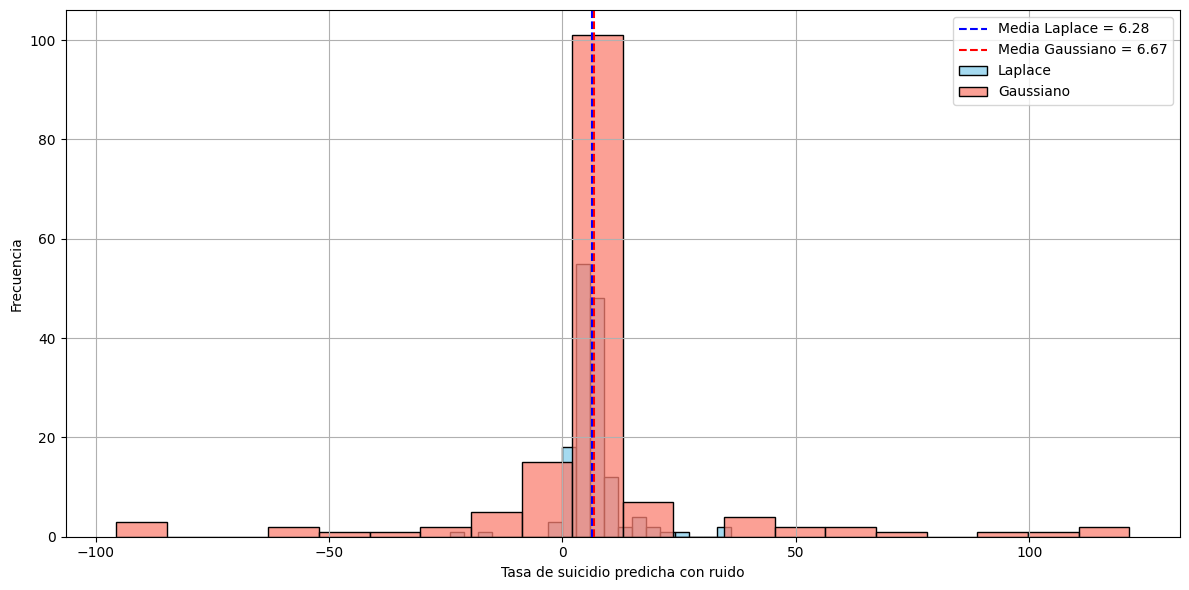

((np.float64(6.275469767422144), 38.406201114367384),
 (np.float64(6.670588148333187), 752.5223477148294))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#media y varianza para cada mecanismo en el caso 3
media_laplace_3 = df_ruido_real[df_ruido_real['mecanismo'] == 'laplace']['suicide_rate_dp'].mean()
var_laplace_3 = df_ruido_real[df_ruido_real['mecanismo'] == 'laplace']['suicide_rate_dp'].var()

media_gauss_3 = df_ruido_real[df_ruido_real['mecanismo'] == 'gaussian']['suicide_rate_dp'].mean()
var_gauss_3 = df_ruido_real[df_ruido_real['mecanismo'] == 'gaussian']['suicide_rate_dp'].var()

#histograma para el caso 3
plt.figure(figsize=(12, 6))
sns.histplot(data=df_ruido_real[df_ruido_real['mecanismo'] == 'laplace'], x='suicide_rate_dp', color='skyblue', label='Laplace', kde=False, bins=20)
plt.axvline(media_laplace_3, color='blue', linestyle='--', label=f'Media Laplace = {media_laplace_3:.2f}')

sns.histplot(data=df_ruido_real[df_ruido_real['mecanismo'] == 'gaussian'], x='suicide_rate_dp', color='salmon', label='Gaussiano', kde=False, bins=20)
plt.axvline(media_gauss_3, color='red', linestyle='--', label=f'Media Gaussiano = {media_gauss_3:.2f}')

plt.xlabel('Tasa de suicidio predicha con ruido')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(media_laplace_3, var_laplace_3), (media_gauss_3, var_gauss_3)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


evaluacion_ruido3 = []
# Itero por tipo de ruido y epsilon
for mecanismo in ['laplace', 'gaussian']:
    for eps in epsilons:
        df_temp3 = df_ruido_real[
            (df_ruido_real['mecanismo'] == mecanismo) &
            (df_ruido_real['epsilon'] == eps)
        ]

# Valores reales sin y con ruido
        y_true3 = df_temp3['suicide_rate']
        y_pred3 = df_temp3['suicide_rate_dp']

# Calculo métricas
        mae3 = mean_absolute_error(y_true3, y_pred3)
        rmse3 = np.sqrt(mean_squared_error(y_true3, y_pred3))
        r2_3 = r2_score(y_true3, y_pred3)

        evaluacion_ruido3.append({
            'mecanismo': mecanismo,
            'epsilon': eps,
            'MAE': round(mae3, 3),
            'RMSE': round(rmse3, 3),
            'R2': round(r2_3, 3)
        })

df_evaluacion_ruido3 = pd.DataFrame(evaluacion_ruido3)

print("\nEvaluación MAE, RMSE y R2 según mecanismo y epsilon en el tercer caso:")
print(df_evaluacion_ruido3.sort_values(['mecanismo', 'epsilon']))



Evaluación MAE, RMSE y R2 según mecanismo y epsilon en el tercer caso:
  mecanismo  epsilon     MAE    RMSE       R2
5  gaussian      0.1  50.525  60.274 -735.288
6  gaussian      0.5   5.519   6.943   -8.769
7  gaussian      1.0   4.096   4.836   -3.741
8  gaussian      5.0   0.778   0.920    0.829
9  gaussian     10.0   0.394   0.501    0.949
0   laplace      0.1   9.466  12.827  -32.348
1   laplace      0.5   1.214   1.938    0.239
2   laplace      1.0   0.721   0.991    0.801
3   laplace      5.0   0.179   0.259    0.986
4   laplace     10.0   0.094   0.127    0.997


In [ ]:
# media y varianza del conjunto completo de predicciones del caso 3
media_original_caso3 = df_ruido_real['suicide_rate_dp'].mean()
varianza_original_caso3 = df_ruido_real['suicide_rate_dp'].var()

# Eliminano aleatoriamente un dato del conjunto de predicciones con ruido
df_ruido_sin_un_dato3 = df_ruido_real.sample(frac=1, random_state=42).iloc[1:]  # Baraja y elimina una fila aleatoriamente

# Calcular media y varianza tras eliminar un dato
media_sin_dato_caso3 = df_ruido_sin_un_dato3['suicide_rate_dp'].mean()
varianza_sin_dato_caso3 = df_ruido_sin_un_dato3['suicide_rate_dp'].var()

df_comparacion_caso3 = pd.DataFrame({
    'Conjunto': ['Original', 'Sin un dato'],
    'Media': [media_original_caso3, media_sin_dato_caso3],
    'Varianza': [varianza_original_caso3, varianza_sin_dato_caso3]
}).round(4)

print("\nComparación de media y varianza antes y después de eliminar un dato (caso 3):")
print(df_comparacion_caso3)



Comparación de media y varianza antes y después de eliminar un dato (caso 2):
      Conjunto   Media  Varianza
0     Original  6.4730  394.1808
1  Sin un dato  6.4785  395.4945
